ЗАДАНИЕ 2

К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям.
Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%. 

In [29]:
import pandas as pd
import numpy as np
import holidays
from fbprophet import Prophet


In [23]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')

In [24]:
# Переименовывам название столбцов
df.rename({'Дата': 'ds', 'Число заказов': 'y'}, axis=1, inplace=True)

In [26]:
df.dtypes

ds    object
y      int64
dtype: object

In [27]:
# Меняем тип даннных в 'ds' на 'datetime'
df['ds'] = pd.to_datetime(df['ds'])

In [45]:
# Почти шестикратный рост к-ва заказов за три месяца
df['y'].max()/df['y'].min() 

5.9338461538461535

In [30]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2016, 2017, 2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
79,2021-03-08,День женщин
80,2021-05-01,Праздник Весны и Труда
81,2021-05-09,День Победы
82,2021-06-12,День России
83,2021-11-04,День народного единства


In [33]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 4

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df[:-predictions]

In [35]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, weekly_seasonality=True)
m.fit(train_df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


In [36]:
# Предсказываем 4 недели
future = m.make_future_dataframe(periods=predictions, freq='W')
forecast = m.predict(future)

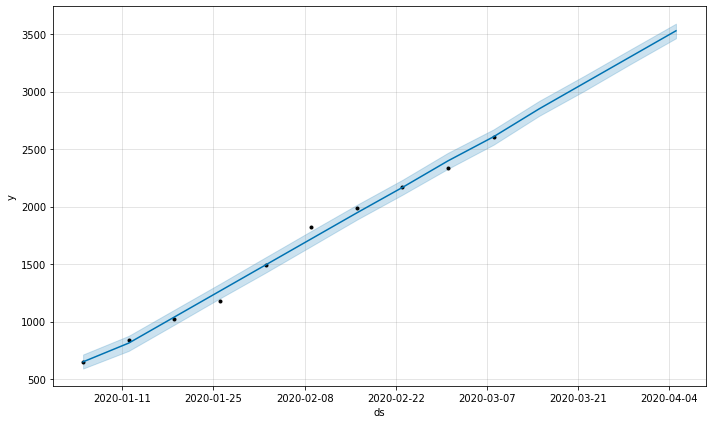

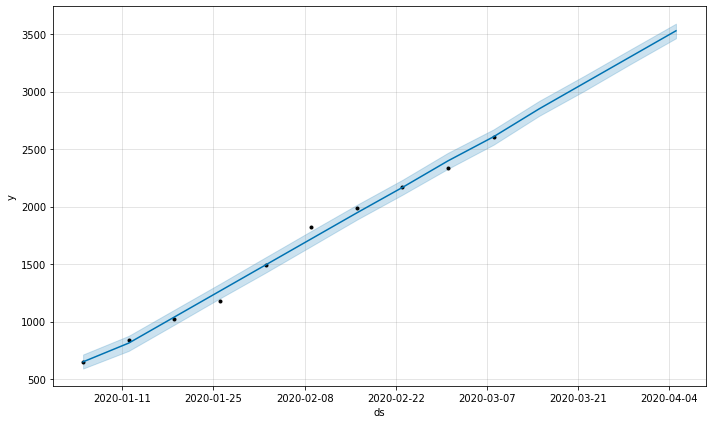

In [38]:
# Смотрим, что предсказалось
m.plot(forecast)

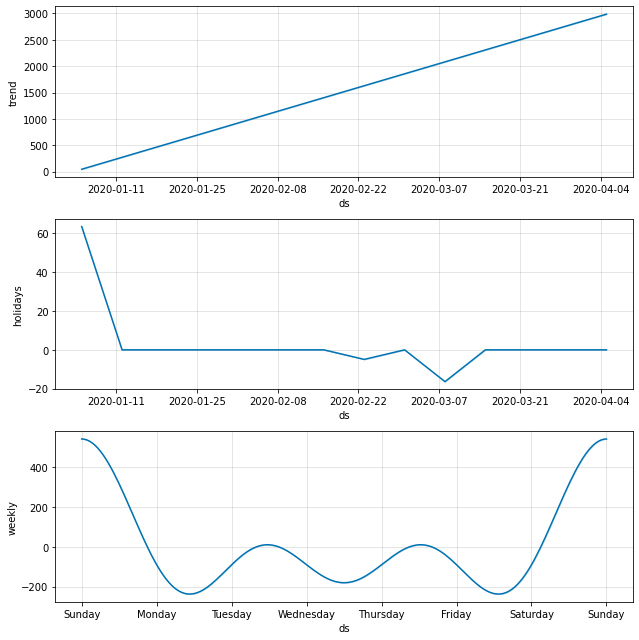

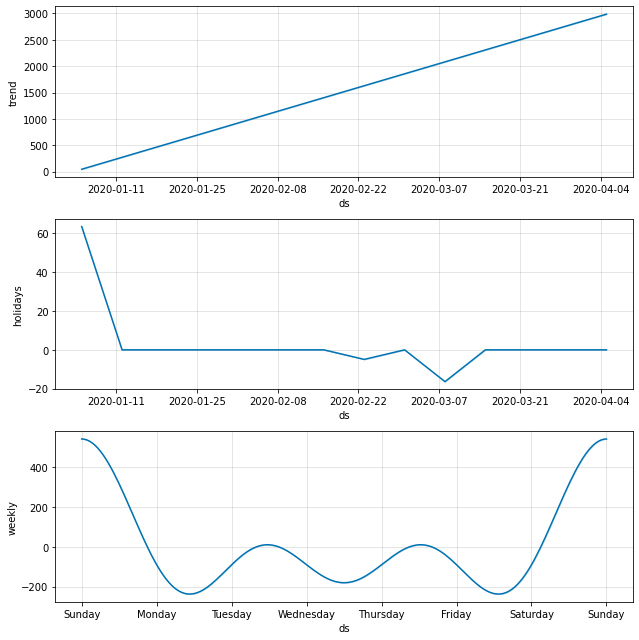

In [39]:
# Смотрим на сезонности
m.plot_components(forecast)

In [13]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [12]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  8.697540080400136 %
MAE (средняя абсолютная ошибка) –  308.3760575322127


In [14]:
# Прогнозируем на полный период (указываем количество недель)
predictions_week = 12
final_train_df = df
f = Prophet(weekly_seasonality=True)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=predictions_week, freq='W')
final_forecast = f.predict(final_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


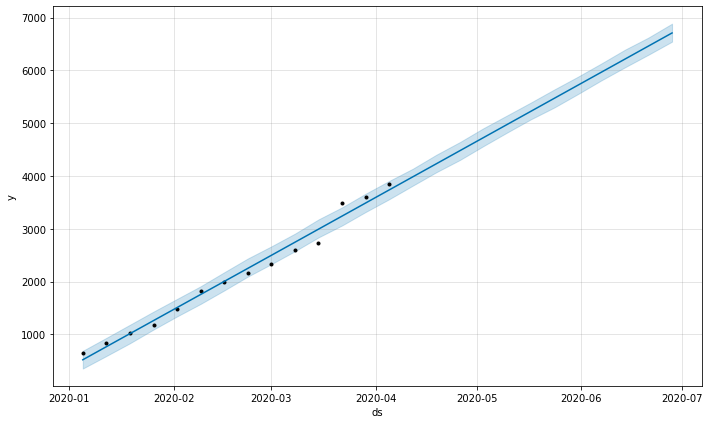

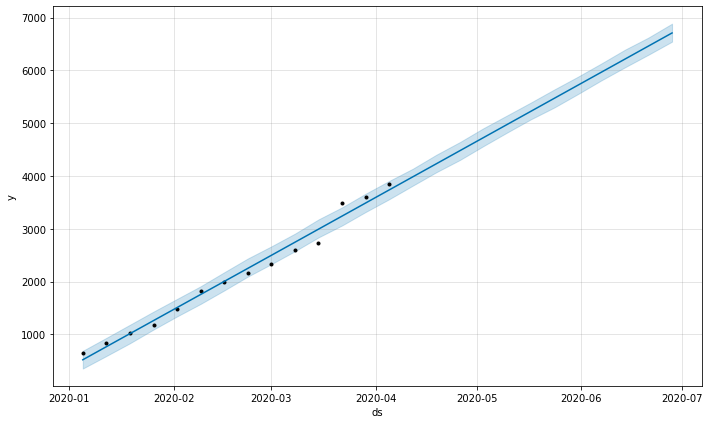

In [40]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast)

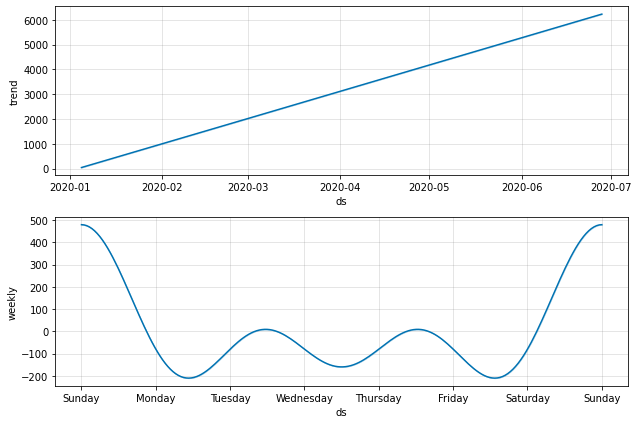

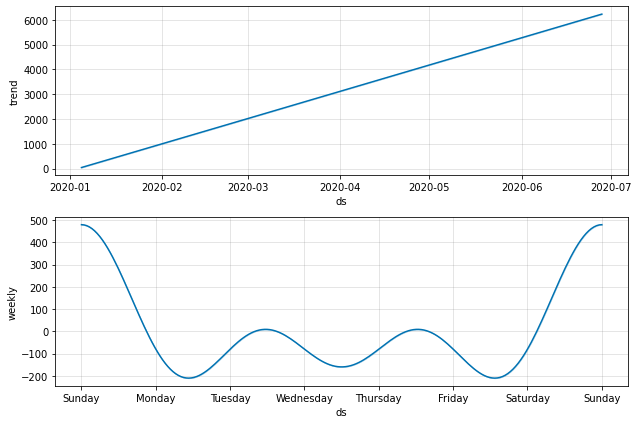

In [17]:
# Смотрим на сезонности в полный период
f.plot_components(final_forecast)

In [41]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions_week:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions_week:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  4.469016974034614 %
MAE (средняя абсолютная ошибка) –  124.36216783310455


In [19]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [46]:
final_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-05,39.973583,352.884912,688.921979,39.973583,39.973583,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,519.421255
1,2020-01-12,287.268615,590.581810,934.102557,287.268615,287.268615,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,766.716287
2,2020-01-19,534.563647,831.898598,1182.607036,534.563647,534.563647,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,1014.011319
3,2020-01-26,781.858679,1091.747498,1431.324957,781.858679,781.858679,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,1261.306351
4,2020-02-02,1029.153712,1340.243552,1671.974358,1029.153712,1029.153712,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,1508.601384
5,2020-02-09,1276.449529,1577.419453,1911.612718,1276.449529,1276.449529,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,1755.897201
6,2020-02-16,1523.786606,1832.297971,2176.623611,1523.786606,1523.786606,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,2003.234278
7,2020-02-23,1771.125348,2094.293992,2437.456862,1771.125348,1771.125348,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,2250.573020
8,2020-03-01,2018.546586,2330.592367,2667.284480,2018.546586,2018.546586,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,2497.994258
9,2020-03-08,2266.227082,2575.782972,2908.097696,2266.227082,2266.227082,479.447672,479.447672,479.447672,479.447672,479.447672,479.447672,0.0,0.0,0.0,2745.674754


In [47]:
df['ds'].max()

Timestamp('2020-04-05 00:00:00')

Итоги: 
Какие выводы мы можем сделать на основе получившегося графика? Как мы видим, prophet предсказывает, опираясь на имеющиеся данные, увеличение количества заказов в следующие 12 недель с MAPE равной почти 8.7%. Можем ли доверять этому прогнозу? К сожалению, нет. Мы не знаем ни природу этих данных, ни причину шестикратного роста за 3 месяца, за исключением акции, приведшей к 7% росту в период с 2020-02-02 по 2020-02-09. Но чем обусловен рост в целом? Увы, но нам не хватает данных, чтобы объективно судить об увеличении количества заказов за данный промежуток времени. По этой причине мы не можем доверять предсказанию prophet-а и вынуждены относиться к нему со очень большоей долей скепсиса. 